# TensorFlow - NLP Emotion Analysis of Reddit Comments

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# load train and test datasets
train_data, test_data = tfds.load(name="goemotions", split=["train", "test"], 
                                  batch_size=-1)
tr = tfds.as_numpy(train_data)
ts = tfds.as_numpy(test_data)

In [4]:
k = list(tr.keys())

In [5]:
tr

{'admiration': array([False,  True, False, ..., False, False, False]),
 'amusement': array([False, False, False, ..., False, False, False]),
 'anger': array([False, False, False, ..., False, False, False]),
 'annoyance': array([False, False, False, ..., False, False, False]),
 'approval': array([False, False, False, ..., False, False, False]),
 'caring': array([False, False, False, ..., False, False, False]),
 'comment_text': array([b"It's just wholesome content, from questionable sources",
        b'This is actually awesome.',
        b"People really spend more than $10 in an app game? I mean an actual video game I can understand but that's just...sad",
        ..., b'Ugh yes that makes sense. Thanks for the response.',
        b"I hope so and I think they have the ability to, but I just have a bad feeling that they won't.",
        b'He\xe2\x80\x99s fine for a 3rd string.'], dtype=object),
 'confusion': array([False, False,  True, ..., False, False, False]),
 'curiosity': array([Fals

In [6]:
k.remove('comment_text')

In [7]:
n = len(k)
m = len(tr['comment_text'])
x = len(ts['comment_text'])

In [8]:
emotion_dict = {}

In [9]:
for i in range(n):
    emotion_dict[k[i]] = i

In [10]:
emotion_dict

{'admiration': 0,
 'amusement': 1,
 'anger': 2,
 'annoyance': 3,
 'approval': 4,
 'caring': 5,
 'confusion': 6,
 'curiosity': 7,
 'desire': 8,
 'disappointment': 9,
 'disapproval': 10,
 'disgust': 11,
 'embarrassment': 12,
 'excitement': 13,
 'fear': 14,
 'gratitude': 15,
 'grief': 16,
 'joy': 17,
 'love': 18,
 'nervousness': 19,
 'neutral': 20,
 'optimism': 21,
 'pride': 22,
 'realization': 23,
 'relief': 24,
 'remorse': 25,
 'sadness': 26,
 'surprise': 27}

In [11]:
train_data = tr
test_data = ts

In [12]:
train_data['comment_text'][:5]

array([b"It's just wholesome content, from questionable sources",
       b'This is actually awesome.',
       b"People really spend more than $10 in an app game? I mean an actual video game I can understand but that's just...sad",
       b'I grew up on the other side of Ama but live in Tulia now. I will have some El Burrito for you',
       b'What the problem? I mean, steak? Good. Doughnuts? Good!! I don\xe2\x80\x99t see an issue. '],
      dtype=object)

In [13]:
train_data['label'] = np.zeros(shape=(1, m), dtype=int)
test_data['label'] = np.zeros(shape=(1, x), dtype=int)

In [14]:
train_data['label'] = train_data['label'][0]
test_data['label'] = test_data['label'][0]

In [15]:
# convert from array of true/false to labels from emotion_dict
z = 0
y = 0
for i in range(m):
    for j in k:
        if train_data[j][i] == True:
            z = int(emotion_dict[j])
    train_data['label'][i] = z
    
for i in range(x):
    for j in k:
        if test_data[j][i] == True:
            y = int(emotion_dict[j])
    test_data['label'][i] = y

In [16]:
train_data = pd.DataFrame({'comment_text':train_data['comment_text'], 'label':train_data['label']})
test_data = pd.DataFrame({'comment_text':test_data['comment_text'], 'label':test_data['label']})

In [17]:
print("Comment:",train_data['comment_text'][0])

Comment: b"It's just wholesome content, from questionable sources"


In [18]:
# decode comments
for i in range(m):
    s = str(train_data['comment_text'][i], 'UTF-8')
    train_data['comment_text'][i] = s

m2 = len(test_data)
for j in range(m2):
    s2 = str(test_data['comment_text'][j], 'UTF-8')
    test_data['comment_text'][j] = s2

<ipython-input-18-ec86e3790db2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['comment_text'][i] = s
<ipython-input-18-ec86e3790db2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['comment_text'][j] = s2


In [19]:
np.array(train_data['comment_text'])

array(["It's just wholesome content, from questionable sources",
       'This is actually awesome.',
       "People really spend more than $10 in an app game? I mean an actual video game I can understand but that's just...sad",
       ..., 'Ugh yes that makes sense. Thanks for the response.',
       "I hope so and I think they have the ability to, but I just have a bad feeling that they won't.",
       'He’s fine for a 3rd string.'], dtype=object)

In [20]:
VOCAB_SIZE = 15000
MAX_SEQUENCE_LENGTH = 50

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    standardize='lower_and_strip_punctuation',
    split='whitespace')

In [21]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dataframe, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [22]:
batch_size = 32
raw_text_ds = df_to_dataset(train_data, shuffle=False, batch_size=batch_size)
raw_test_ds = df_to_dataset(test_data, shuffle=False, batch_size=batch_size)

In [23]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_text_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [24]:
train, val = train_test_split(train_data, test_size=0.3)

In [25]:
raw_train_ds = df_to_dataset(train, batch_size=batch_size)
raw_val_ds = df_to_dataset(val, batch_size=batch_size)

In [26]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Comment:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

Comment: [b'I wanna give [NAME] a mosquito bite']
Label: 8
Comment: [b"I've debated shaving my head just to avoid this. My haircuts often get stretched several extra weeks because i'm dreading it."]
Label: 20
Comment: [b'Ah ok. Thank you!']
Label: 15
Comment: [b'I feel left out... I never get invited to our new world order meetings with our elders of zion']
Label: 26
Comment: [b'But still, crying "castrate all pedophiles" because they could be potential rapists is like crying "kill all men, they are all potential rapists." ']
Label: 26


In [27]:
def vectorize_text(text, label):
  return vectorize_layer(text), label

In [28]:
text_batch, label_batch = next(iter(raw_train_ds))
first_comment, first_label = text_batch[0], label_batch[0]
print("Comment:", first_comment)
print("Label:", int(first_label))
print("Emotion:", [k for k,v in emotion_dict.items() if v == int(first_label)])
print("Vectorized comment:", vectorize_text(first_comment, first_label))

Comment: tf.Tensor([b'That\xe2\x80\x99s like forcing skins back in the days of MOHAA everyone is fluoro Orange! That\xe2\x80\x99s what they want!'], shape=(1,), dtype=string)
Label: 20
Emotion: ['neutral']
Vectorized comment: (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[ 141,   26, 2563, 2922,  118,   14,    2,  379,   12,    1,  196,
           8,    1, 1709,  141,   32,   29,  108,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int64)>, <tf.Tensor: shape=(), dtype=int32, numpy=20>)


In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
embedding_dim = 140
# Embed a 15,000 word vocabulary into 140 dimensions.
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim)

In [31]:
model = keras.models.Sequential([
    vectorize_layer,
    embedding_layer,
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.4),
    layers.Dense(28, activation='relu'),
    layers.Dense(28, activation='tanh'),
    layers.Dense(28, activation='relu')
])

In [32]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
epochs = 15
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose=1)

Epoch 1/15
950/950 [==============================] - 19s 20ms/step - loss: 2.8637 - accuracy: 0.3129 - val_loss: 2.5172 - val_accuracy: 0.3685
Epoch 2/15
950/950 [==============================] - 17s 18ms/step - loss: 2.4032 - accuracy: 0.4006 - val_loss: 2.2526 - val_accuracy: 0.4566
Epoch 3/15
950/950 [==============================] - 17s 18ms/step - loss: 2.1184 - accuracy: 0.4774 - val_loss: 2.1862 - val_accuracy: 0.4696
Epoch 4/15
950/950 [==============================] - 17s 18ms/step - loss: 1.9540 - accuracy: 0.5072 - val_loss: 2.1552 - val_accuracy: 0.4822
Epoch 5/15
950/950 [==============================] - 18s 18ms/step - loss: 1.8205 - accuracy: 0.5358 - val_loss: 2.1696 - val_accuracy: 0.4784
Epoch 6/15
950/950 [==============================] - 17s 18ms/step - loss: 1.7062 - accuracy: 0.5665 - val_loss: 2.1895 - val_accuracy: 0.4795
Epoch 7/15
950/950 [==============================] - 17s 18ms/step - loss: 1.6129 - accuracy: 0.5898 - val_loss: 2.2183 - val_accuracy:

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 140)           2100000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 140)               0         
_________________________________________________________________
dropout (Dropout)            (None, 140)               0         
_________________________________________________________________
dense (Dense)                (None, 28)                3948      
_________________________________________________________________
dense_1 (Dense)              (None, 28)                812       
_________________________________________________________________
dense_2 (Dense)              (None, 28)                8

In [35]:
model_pred1 = model.predict(["This is about as *middle* a statement as you can get. We're looking for label '20'."])
pred_label1 = np.argmax(model_pred1)
print("Model prediction for label: ", pred_label1)
print("Predicted emotion: ", [k for k,v in emotion_dict.items() if v == pred_label1])

Model prediction for label:  20
Predicted emotion:  ['neutral']


In [36]:
model_pred2 = model.predict(["i'm laughing out loud"])
pred_label2 = np.argmax(model_pred2)
print("Model prediction for label: ", pred_label2)
print("Predicted emotion: ", [k for k,v in emotion_dict.items() if v == pred_label2])

Model prediction for label:  1
Predicted emotion:  ['amusement']


In [37]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

407/407 [==============================] - 0s 1ms/step - loss: 2.5880 - accuracy: 0.4395
Loss:  2.5880320072174072
Accuracy:  0.43953007459640503


In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

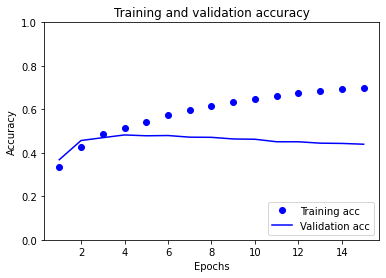

In [40]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.show()

Next steps:

-Improve validation accuracy

-Fine-tune hyperparameters

-Experiment with layers, nodes

-Experiment with activation, optimization, loss functions

-Incorporate LSTM to account for sentence structure